In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint
import numpy as np
import matplotlib.pyplot as plt

# from IPython.display import Image
from IPython.core.display import Image, display

import h5py
from functools import reduce

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Device: ',device)

Device:  cuda


## define NN structure

In [20]:
## define VAE structure
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1, 1)
    
class VAE(nn.Module):
    def __init__(self, device, image_channels=1, h_dim=256, z_dim=16):
        super(VAE, self).__init__()
        
        self.cov_layer_set = nn.Sequential(
            # 1 * 16 * 16 * 16
            nn.Conv3d(in_channels=image_channels, out_channels=16, 
                      kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool3d(2,return_indices=True)
        )
        
        self.encoder = nn.Sequential(
            # 16 * 7 * 7 * 7
            nn.Conv3d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=1),
            nn.ReLU(),
            # 32 * 5 * 5 * 5
            nn.Conv3d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1),
            nn.ReLU(),
            # 64 * 3 * 3 * 3
            nn.Conv3d(in_channels=64, out_channels=256, 
                      kernel_size=3, stride=1),
            nn.ReLU(),
            # 256 * 1 * 1 * 1
            Flatten()
            # 256
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim) # for mu
        self.fc2 = nn.Linear(h_dim, z_dim) # for sigma
        self.fc3 = nn.Linear(z_dim, h_dim) # for decoder
        
        self.decoder = nn.Sequential(
            # 256
            UnFlatten(),
            # 256 * 1 * 1 * 1
            nn.ConvTranspose3d(h_dim, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=1),
        )
        self.unpool = nn.MaxUnpool3d(2)
        self.decov_layer_set = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose3d(16, image_channels, kernel_size=3, stride=1),
            nn.Sigmoid())
        
    def decov_layer(self, z, indice):
        z = self.unpool(z, indice)
        z = self.decov_layer_set(z)
        return z
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return std
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        x, indice = self.cov_layer_set(x)
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar, indice

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar, indice = self.encode(x)
        z = self.decode(z)
        z = self.decov_layer(z, indice)
        
        return z, mu, logvar

## Define loss function

In [3]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

## Pre-define some Constant Variables

In [27]:
BATCH_SIZE = 32
EPOCH = 100
Z_DIM = 8

NORMAL_CLASS = 0
ABNORMAL_CLASS = 1

## Read data and pre-processing

In [5]:
with h5py.File(r"./full_dataset_vectors.h5", "r") as hf:
    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:]
    targets_test = hf["y_test"][:]

train_dataset = torch.tensor(X_train[targets_train == NORMAL_CLASS,:].reshape(-1,1,16,16,16)).type(torch.float)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=1, pin_memory=True)

n_idx = targets_test == NORMAL_CLASS
a_idx = targets_test == ABNORMAL_CLASS
test_x = torch.cat([torch.tensor(X_test[n_idx,:].reshape(-1,1,16,16,16)),
                    torch.tensor(X_test[a_idx,:].reshape(-1,1,16,16,16))]).type(torch.float)
test_y = torch.cat([torch.tensor(targets_test[n_idx]),
                    torch.tensor(targets_test[a_idx])])
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                              shuffle=False, num_workers=1, pin_memory=True)

# print(normMean, normStd)

In [6]:
targets_test

array([7, 7, 2, ..., 8, 9, 9])

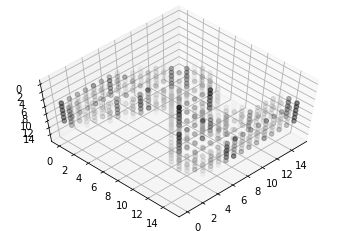

In [7]:
def plot_3Dvoxel(Voxel):
    sample_shape = Voxel.shape
    sample_len = reduce(lambda x,y: x*y, sample_shape[0:3])

    x,y,z = [np.reshape(c, [sample_len, 1]) for c in np.meshgrid(range(sample_shape[0]),
                                                                 range(sample_shape[1]),
                                                                 range(sample_shape[2]))]

    rgba = [(1-r,1-r,1-r,r) for r in np.reshape(Voxel,[sample_len,])]

    fig = plt.figure()
    axes = fig.gca(projection='3d')
    axes.scatter3D(x,y,z, facecolor=rgba)
    #     axes.voxels(filled)
    axes.view_init(elev=-120, azim=-45)

plot_3Dvoxel(X_train[0].reshape(16,16,16))

## Define and train model

In [21]:
model = VAE(device, z_dim=Z_DIM).to(device)
print('Model: \n', model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Model: 
 VAE(
  (cov_layer_set): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): ReLU()
    (6): Flatten()
  )
  (fc1): Linear(in_features=256, out_features=8, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=256, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose3d(256, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (2): ReLU()
    (3): ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (unpool)

In [33]:
## train model
best_LOSS = 1e10
for epoch in range(EPOCH):
    LOSS = 0.
    for idx, images in enumerate(train_dataloader):
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:    
        to_print = "Epoch[{}/{}], Iter: {}, Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, EPOCH, idx,
                        loss.data.item()/BATCH_SIZE, bce.data.item()/BATCH_SIZE, kld.data.item()/BATCH_SIZE)
        print(to_print)
    # test and choose the best model
    model.eval()
    with torch.no_grad():
        num = 0
        for idx, (images, target) in enumerate(test_dataloader):
            if target == 0:
                num += 1
                images = images.to(device)
                recon_images, mu, logvar = model(images)
                loss_t, _, _ = loss_fn(recon_images, images, mu, logvar)
                LOSS += loss_t
        LOSS = LOSS/num
        if LOSS<best_LOSS:
            best_LOSS = LOSS
            torch.save(model.state_dict(), '3d_fdd_vae.torch')
#         print('LOSS: ', LOSS.item(), 'best LOSS: ', best_LOSS.item())
                
    model.train()

model.load_state_dict(torch.load('3d_fdd_vae.torch'))
# torch.save(model.state_dict(), '3d_fdd_vae.torch')

Epoch[1/100], Iter: 29, Loss: 643.971 643.610 0.360
Epoch[11/100], Iter: 29, Loss: 594.940 594.585 0.355
Epoch[21/100], Iter: 29, Loss: 605.587 605.241 0.346
Epoch[31/100], Iter: 29, Loss: 593.828 593.508 0.320
Epoch[41/100], Iter: 29, Loss: 584.666 584.333 0.333
Epoch[51/100], Iter: 29, Loss: 571.383 571.006 0.377
Epoch[61/100], Iter: 29, Loss: 532.856 532.550 0.306
Epoch[71/100], Iter: 29, Loss: 564.927 564.652 0.275
Epoch[81/100], Iter: 29, Loss: 555.309 555.092 0.217
Epoch[91/100], Iter: 29, Loss: 533.147 532.906 0.241


<All keys matched successfully>

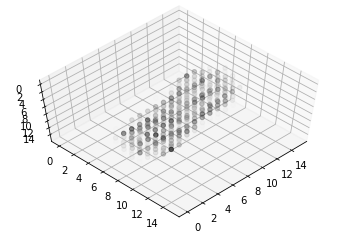

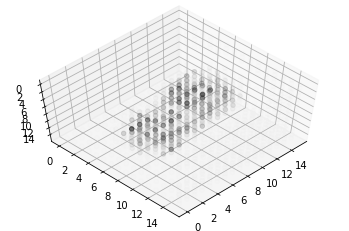

In [36]:
test_idx = -1
with torch.no_grad():
    plot_3Dvoxel(test_x[test_idx].view(16,16,16))
    plot_3Dvoxel(model(test_x[test_idx].view(1,1,16,16,16).to(device))[0].reshape(16,16,16).cpu())